
# TVM - Vitis AI YoloV3 tutorial

## Introduction

Apache TVM is a versatile framework that integrates the high-performance computing power of Xilinx Vitis AI DPUs with the flexibility of the TVM framework to accelerate models from many different training frameworks supported by TVM in a matter that is seamless to the end-user. This flow provides a solution for compiling and running custom models with unsupported operations with the Vitis AI Development Kit, as depicted below. The aim of this tutorial is to demonstrate how to accelerate a custom YoloV3 model taken from a public repository.

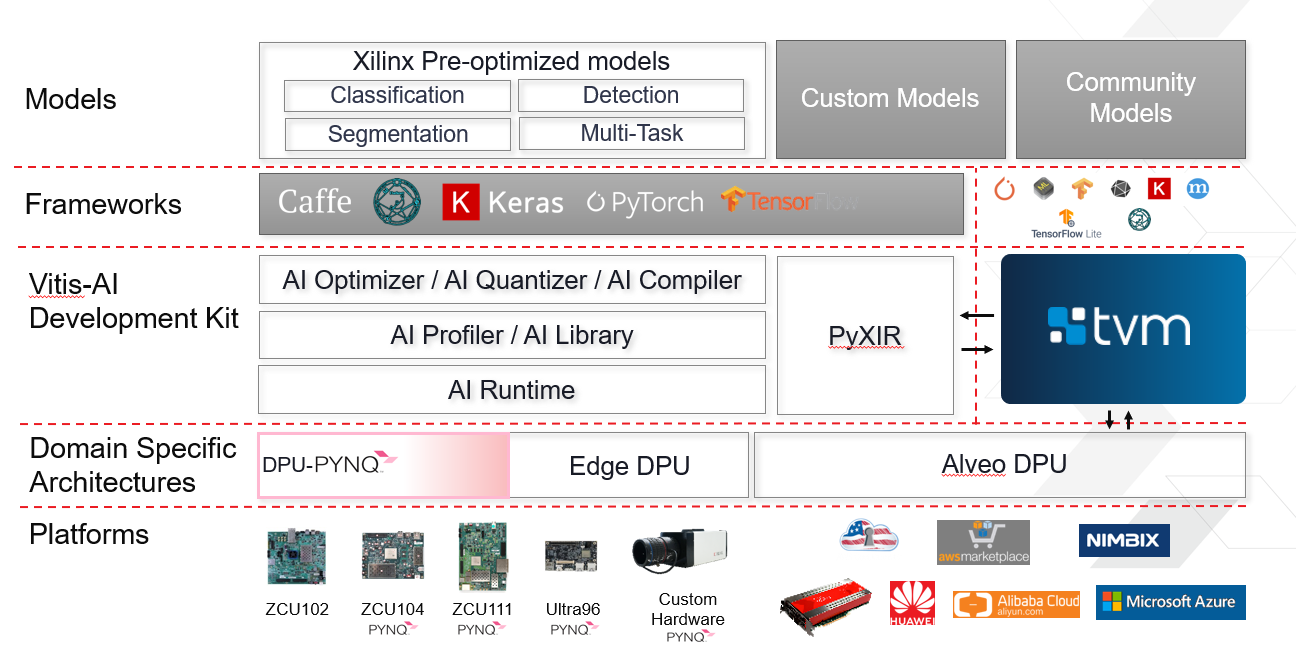


## Setup

Before we proceed, please ensure that you have followed the README.md file in the _VITIS_REPO/external/tvm_ directory to properly setup your system for your specific Alveo DPU or Zynq DPU target. Once successfully done so, you can run this notebook inside the docker container.

Once in the docker, ensure you activate the conda environment before running this example by:
> conda activate vitis-ai-tensorflow

You start a jupyter server inside the docker by:
> jupyter notebook --allow-root --ip 0.0.0.0 --no-browser

#### Install and setup the custom YoloV3 model

The custom model we will compile for DPU acceleration is a Tensorflow YoloV3 model from [this] Github repository. The repository contains instructions for obtaining a frozen pb file. This model incorporates operations that are not directly supported by the primary Vitis AI Development Kit. As a result, this notebook explains how the TVM with Vitis AI flow can be used instead to accelerate the custom model while using the Vitis AI backend hardware.

To further demonstrate TVM with Vitis AI support for different frameworks, we also converted the custom YoloV3 Tensorflow model to ONNX format and provide instructions below to import either the Tensorflow Model or the ONNX model.

Run following command to download the YoloV3 model and necessary utilities:

[this]: https://github.com/YunYang1994/tensorflow-yolov3

In [ ]:
!bash setup_custom_yolov3.sh

## Import packages

We start by importing the proper TVM and PyXIR packages to compile and run the model. The PyXIR package is an abstraction that facilitate the TVM integration with the Vitis AI stack.

In [ ]:
import numpy as np
import os, sys
import os.path
import tensorflow as tf
from pathlib import Path

# pyxir
import pyxir
import pyxir.contrib.target.DPUCADF8H
import pyxir.contrib.target.DPUCAHX8H
import pyxir.contrib.target.DPUCAHX8L
import pyxir.contrib.target.DPUCVDX8H
import pyxir.contrib.target.DPUCZDX8G

# tvm, relay
import tvm
from tvm import te
from tvm import contrib
import tvm.relay as relay


# BYOC
from tvm.relay import transform
from tvm.contrib import utils, graph_executor
from tvm.contrib.target import vitis_ai
from tvm.relay.build_module import bind_params_by_name
from tvm.relay.op.contrib.vitis_ai import annotation
# Tensorflow utility functions
import tvm.relay.testing.tf as tf_testing
from tvm.contrib.download import download_testdata
from tvm.relay.op.contrib.vitis_ai import partition_for_vitis_ai



import cv2

try:
    tf_compat_v1 = tf.compat.v1
except ImportError:
    tf_compat_v1 = tf


## Define preprocessing functions

Below we define a set of preprocessing functions pertaining to the tensorflow _Yolov3_ model. 

In [ ]:
def preprocessing(image):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

    ih, iw    = (320,320)
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_padded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_padded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_padded = image_padded / 255.

    return image_padded

   
def transform_image(image):
    image = np.array(image)[np.newaxis, :]
    return image


## Prepare input and specify the Vitis DPU target

We proceed by reading in the test image for object detection, and specifying the Vitis target for compiling and running the model. You can choose your DPU target from the dropdown menu below.

In [ ]:
import ipywidgets as widgets

v_target = widgets.Dropdown(
    options=["DPUCADF8H", "DPUCAHX8H-u50lv", "DPUCAHX8H-u50lv_dwc", "DPUCAHX8H-u55c_dwc", "DPUCZDX8G-zcu104", "DPUCZDX8G-zcu102"],
    value='DPUCADF8H',
    description='Vitis Target:',
    disabled=False,
)
display(v_target)

In [ ]:
from PIL import Image
img_path = "/tmp/tensorflow-yolov3/docs/images/road.jpeg"
original_image = cv2.imread(img_path)
image = preprocessing(original_image) 
image = np.array(image)[np.newaxis, :]

print("Vitis Target: ", v_target.value)
input_name     = 'input/input_data'
shape_dict     = {input_name: image.shape}
postprocessing = []
vitis_target   = v_target.value
tvm_target     = 'llvm'
lib_kwargs     = {}



## Import the model to TVM

The TVM with Vitis AI support provides ease of use by following the TVM flow for compiling and running models. As such, we leverage the frontend capabilities of the TVM framework for importing models. As an example, [Import Tensorflow] document from TVM demonstrates how to import and compile Tensorflow models using only the TVM compiler. Similarly, [Import ONNX] document shows how an ONNX model can be imported into the TVM framework. Below we provide a dropdown menu where you can choose which model you would like to import to run through the TVM - Vitis AI flow. The main differences between the two models are setting the proper "input_name" defined by the model, and using _"relay.frontend.from_onnx()"_ as opposed to _"relay.frontend.from_tensorflow()"_ to import the model into TVM. The rest of the flow remains identical irrespective of the type of the model.

Lastly, we use _"transform.RemoveUnusedFunctions()(mod)"_ in order to remove any dangling nodes that may cause interference with the design compilation.

[Import Tensorflow]: https://tvm.apache.org/docs/tutorials/frontend/from_tensorflow.html
[Import ONNX]: https://tvm.apache.org/docs/tutorials/frontend/from_onnx.html

In [ ]:
import ipywidgets as widgets

framework = widgets.Dropdown(
    options=['TF', 'ONNX'],
    value='TF',
    description='Framework:',
    disabled=False,
)
display(framework)

In [ ]:
print ("Framework: ", framework.value)
if framework.value == "TF":
    model_path = "/tmp/tensorflow-yolov3/yolov3_coco.pb"
    with tf_compat_v1.gfile.GFile(model_path, "rb") as f:
        graph_def = tf_compat_v1.GraphDef()
        graph_def.ParseFromString(f.read())
        graph = tf.import_graph_def(graph_def, name="")
        # Call the utility to import the graph definition into default graph.
        graph_def = tf_testing.ProcessGraphDefParam(graph_def)
        # Add shapes to the graph.
        with tf_compat_v1.Session() as sess:
            graph_def = tf_testing.AddShapesToGraphDef(sess, "pred_sbbox/concat_2")
    mod, params = relay.frontend.from_tensorflow(graph_def, shape=shape_dict)
    print("Tensorflow protobuf imported to relay frontend.")
    
else:
    import onnx
    input_name     = 'input/input_data:0'
    shape_dict     = {input_name: image.shape}
    model_path = "/tmp/tensorflow-yolov3/tf_yolov3_converted.onnx"
    onnx_model = onnx.load(model_path)
    mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)


## Partitioning the model

In order to support models with custom operations, we annotate and partition the graph to coalesce the operations supported by the DPU target. During runtime, the partitioned graph is accelerated while the remaining nodes are executed on CPU. Below we present the API to partition the TVM module.

In [ ]:
mod = partition_for_vitis_ai(mod, params, dpu=vitis_target)

## Build the partitioned TVM module

Once the TVM module is successfully partitioned, we build the module for the provided Vitis target using the TVM APIs. The partitioned model is passed to the TVM compiler. The TVM compiler generates the runtime libraries for the sepecifed target.

In [ ]:
export_rt_mod_file = os.path.join(os.getcwd(), 'vitis_ai.rtmod')

build_options = {
    'dpu': vitis_target,
    'export_runtime_module': export_rt_mod_file
}

with tvm.transform.PassContext(opt_level=3, config={'relay.ext.vitis_ai.options': build_options}):   
    lib = relay.build(mod, tvm_target, params=params)

## Quantize the model

As part of its compilation process, The TVM with Vitis AI flow automatically performs quantization for the target hardware. To do so, we make use of our added On-The-Fly (OTF) Quantization feature. Using this method one doesn’t need to quantize their model upfront, but instead we can make use of the typical inference execution calls (module.run) to calibrate the model on-the-fly using the first N inputs that are provided, where N is the number of quantization images. After the first N iterations, computations will be accelerated on the DPU. So, now we will feed N inputs to the TVM runtime module. Note that these first N inputs will take a substantial amount of time. You can change N by setting the  PX_QUANT_SIZE environment variable. The default value is set to 128 images.

We need a set of images for quantization and a callback function that needs to perform the model preprocessing on the quantization images and to return a dictionary mapping from input name to array containing dataset inputs. In this example we currently use the imagenet dataset images for quantization, but the user can choose a different dataset of their choice.

In [ ]:
QUANT_DIR = os.path.join("/opt/tvm-vai", "CK-TOOLS/dataset-imagenet-ilsvrc2012-val-min/")

def inputs_func(img_files):
    inputs = []
    for img_path in img_files:
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocessing(image)

        inputs.append(transform_image(image))
    return inputs  


print("Create InferenceSession for OTF Quantization")
module = graph_executor.GraphModule(lib["default"](tvm.cpu()))
 
px_quant_size = int(os.environ['PX_QUANT_SIZE']) \
    if 'PX_QUANT_SIZE' in os.environ else 128
 
print("Start OTF Quantization on first {} images".format(px_quant_size))
 
quant_files = [os.path.join(QUANT_DIR, f) for f in os.listdir(QUANT_DIR)
             if f.endswith(('JPEG', 'jpg', 'png'))][:px_quant_size]
quant_images = inputs_func(quant_files)
print('Loaded {} inputs successfully.'.format(len(quant_images)))
 
for i in range(px_quant_size):
    module.set_input(input_name, quant_images[i])
    module.run()

print("Finished OTF Quantization")

## Export and run on a Zynq edge device

Skip this section if you plan to run this example on an Alveo target.

If you are targetting a Zynq device, then before proceeding, make sure you have set up the Zynq device by following the instructions in _VITIS_REPO/third_party/tvm/docs/running_on_zynq.md_ 

Below we export the compiled model for any of the supported edge devices. Afterwards, you will have to transfer this compiled model to your edge device and use _"run_external_yolov3.py"_ script in _VITIS_REPO/third_party/tvm/examples_ directory to run the compiled model on your device.

In [ ]:
if vitis_target.startswith('DPUCZDX8G'):

    # Export runtime module
    temp = utils.tempdir()
    lib.export_library(temp.relpath("tvm_lib.so"))
    
    # Build and export lib for aarch64 target
    tvm_target = tvm.target.arm_cpu('ultra96')
    lib_kwargs = {
        'fcompile': contrib.cc.create_shared,
        'cc': "/usr/aarch64-linux-gnu/bin/ld"
    }
    build_options = {
        'load_runtime_module': export_rt_mod_file
    }

    with tvm.transform.PassContext(opt_level=3, config={'relay.ext.vitis_ai.options': build_options}): 
        lib_dpuczdx8g = relay.build(mod, tvm_target, params=params)
 
    lib_dpuczdx8g.export_library('tvm_dpu_cpu.so', **lib_kwargs)
    
else:
    lib.export_library('tvm_dpu_cpu.so')
    
print("Finished storing the compiled model as tvm_dpu_cpu.so")

## Run on an Alveo device

Once the model is successfully compiled, and your TVM with Vitis AI support docker is setup on a machine that includes an Alveo board, you can proceed and run the compiled model directly inside the docker. Below we present an example of running the compiled YoloV3 model on a sample image. The detection image is stored as output.png which can be examined.

In [ ]:
# load post-processing libs
if '/tmp/tensorflow-yolov3' not in sys.path:
    sys.path.append('/tmp/tensorflow-yolov3/')
import core.utils as utils

module = graph_executor.GraphModule(lib["default"](tvm.cpu()))
module.set_input(input_name,image)
module.run()

res = module.get_output(0).asnumpy()
num_classes = 80
input_size = 320
pred_bbox = res.reshape(-1,85)
original_image_size = original_image.shape[:2]
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)
bboxes = utils.nms(bboxes, 0.45, method='nms')
image = utils.draw_bbox(original_image, bboxes)
cv2.imwrite("./output.png", (image))

This concludes the tutorial on using TVM with Vitis AI support to run a custom YoloV3 model. For more documentation and examples, refer to _VITIS_REPO/third_party/tvm/docs_ and _VITIS_REPO/third_party/tvm/examples/_.
